In [3]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)


# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os


# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    

from matplotlib import font_manager, rc
import platform


path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)


mpl.rcParams['axes.unicode_minus'] = False


# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한 
%precision 3


import seaborn as sns

import scipy as sp
from scipy import stats


# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"


# 노트북 실행 결과를 동일하게 유지하기 위해
# 데이터를 분할할 때 동일한 분할을 만들기 위해서
# 모델을 만드는 작업을 여러 번에 걸쳐서 하는 경우 시드가 변경되면
# 훈련용 데이터가 자주 변경되면 결국 모든 데터를 가지고 모델을 생성하는 결과
# Outfit을 만드는 효과를 가져옴.
np.random.seed(42)

In [4]:
df = sns.load_dataset('titanic')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


# 결측치 처리

In [5]:
rdf = df.drop(['deck', 'embark_town'], axis=1)
rdf = rdf.dropna(subset=['age'], how='any', axis=0)
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()
rdf['embarked'].fillna(most_freq, inplace=True)
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    714 non-null    int64   
 1   pclass      714 non-null    int64   
 2   sex         714 non-null    object  
 3   age         714 non-null    float64 
 4   sibsp       714 non-null    int64   
 5   parch       714 non-null    int64   
 6   fare        714 non-null    float64 
 7   embarked    714 non-null    object  
 8   class       714 non-null    category
 9   who         714 non-null    object  
 10  adult_male  714 non-null    bool    
 11  alive       714 non-null    object  
 12  alone       714 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(4)
memory usage: 63.6+ KB


# one hot encoding
순서가 없는 범주형 데이터

In [6]:
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

# 순서가 없는 ㅓㅁ주형 데이터의 원 핫 인코딩
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)

ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  714 non-null    int64  
 1   pclass    714 non-null    int64  
 2   age       714 non-null    float64
 3   sibsp     714 non-null    int64  
 4   parch     714 non-null    int64  
 5   female    714 non-null    uint8  
 6   male      714 non-null    uint8  
 7   town_C    714 non-null    uint8  
 8   town_Q    714 non-null    uint8  
 9   town_S    714 non-null    uint8  
dtypes: float64(1), int64(4), uint8(5)
memory usage: 37.0 KB


In [7]:
#피쳐 와 타켓을 분리
X = ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 'town_C', 'town_Q', 'town_S']]
y = ndf ['survived']
#정규화
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
print(X[0:5])

[[ 0.911 -0.53   0.525 -0.506 -0.759  0.759 -0.472 -0.202  0.533]
 [-1.476  0.572  0.525 -0.506  1.317 -1.317  2.12  -0.202 -1.876]
 [ 0.911 -0.255 -0.552 -0.506  1.317 -1.317 -0.472 -0.202  0.533]
 [-1.476  0.365  0.525 -0.506  1.317 -1.317 -0.472 -0.202  0.533]
 [ 0.911  0.365 -0.552 -0.506 -0.759  0.759 -0.472 -0.202  0.533]]


#### 훈련 데이터와 테스트 데이터 분할
데이터가 랜덤하게 배치되어 있다면 분할할 때 순서대로 앞에서 일정 부분은 <br/>
훈련 데이터로 사용하고 일정 부분은 테스트 데이터로 할당<br/>

타겟의 비율을 고려<br/>
타겟의 비율이 고르지 않다면 여러가지 고려<br/>
층화 추출, oversampling, undersampling 고려<br/>
이상치 탐지에서 이 부분이 항상 고려 대상.<br/>

**titanic은 항구별로 순차적인 데이터를 가지고 있을 가능성이 매우 높다**

- 훈련 데이터의 비율 - 일반적으로 0.7, 0.8을 많이 사용

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
# 모델을 만들어서 훈련
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=25, random_state=42, n_jobs=-1)

forest.fit(X_train,y_train)

RandomForestClassifier(n_estimators=25, n_jobs=-1, random_state=42)

# 평가 지표 확인

In [10]:
y_hat = forest.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 1 1 1 0 1 0 1 1 1]
[0 1 1 1 0 1 1 1 0 0]


In [11]:
from sklearn import metrics

# 오차 행렬 확인
tree_matrix = metrics.confusion_matrix(y_test, y_hat)
print(tree_matrix)

# 정확도 계산
print((tree_matrix[0, 0] + tree_matrix[1, 1]) / np.sum(tree_matrix))

[[106  20]
 [ 24  65]]
0.7953488372093023


In [12]:
tree_report = metrics.classification_report(y_test, y_hat)
print(tree_report)

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       126
           1       0.76      0.73      0.75        89

    accuracy                           0.80       215
   macro avg       0.79      0.79      0.79       215
weighted avg       0.79      0.80      0.79       215



<function matplotlib.pyplot.show(close=None, block=None)>

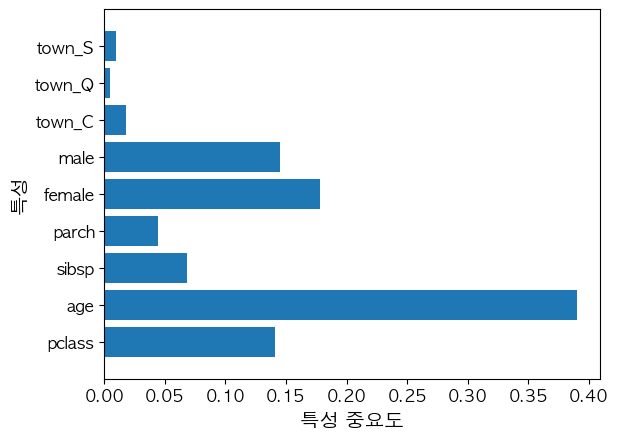

In [13]:
n_features = X.data.shape[1]
plt.barh(np.arange(n_features), forest.feature_importances_, align='center')
plt.yticks(np.arange(n_features),
           ['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 'town_C', 'town_Q', 'town_S'])
plt.xlabel('특성 중요도')
plt.ylabel('특성')
plt.ylim(-1, n_features)
plt.show
           
           

In [14]:
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Algorithm 은 확률을 계산할 수 있으면 SAMME.R 이고 없으면 SAMME
# learning_rate는 학습률
# 학습률이 너무 크면 최적화되지 않을 가능성이 커지고, 너무 작으면 훈련 속도 느려짐. (overfitting)
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators= 200,
    algorithm='SAMME.R',
    learning_rate=0.5,
    random_state=42
)

ada_clf.fit(X_train, y_train)

# 평가 지표 확인
y_hat = ada_clf.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 1 1 1 0 0 0 0 1 1]
[0 1 1 1 0 1 1 1 0 0]


In [15]:
#오차 행렬 확인
ada_matrix = metrics.confusion_matrix(y_test, y_hat)
print(ada_matrix)

#정확도 계산
print((ada_matrix[0, 0] + ada_matrix[1,1]) / np.sum(ada_matrix))

ada_report = metrics.classification_report(y_test, y_hat)
print(ada_report)

[[99 27]
 [24 65]]
0.7627906976744186
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       126
           1       0.71      0.73      0.72        89

    accuracy                           0.76       215
   macro avg       0.76      0.76      0.76       215
weighted avg       0.76      0.76      0.76       215



In [16]:
%%time

# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

gbm_clf = GradientBoostingClassifier(random_state=42)

gbm_clf.fit(X_train, y_train)

# 평가 지표 확인
y_hat = gbm_clf.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 1 1 1 0 1 0 1 0 1]
[0 1 1 1 0 1 1 1 0 0]
CPU times: user 39.4 ms, sys: 1.67 ms, total: 41.1 ms
Wall time: 41.3 ms


In [17]:
# 오차 행렬
gbm_matrix = metrics.confusion_matrix(y_test, y_hat)
print(gbm_matrix)

print((gbm_matrix[0, 0] + gbm_matrix[1, 1]) / np.sum(gbm_matrix))

[[108  18]
 [ 25  64]]
0.8


In [20]:
%%time
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 500],
    'learning_rate': [0.05, 0.1]
}

grid_cv = GridSearchCV(gbm_clf, param_grid=params, cv=2, verbose=1)
grid_cv.fit(X_train, y_train)
print('최적의 파라미터:', grid_cv.best_params_)
print('최적의 정확도:', grid_cv.best_score_)


Fitting 2 folds for each of 4 candidates, totalling 8 fits
최적의 파라미터: {'learning_rate': 0.1, 'n_estimators': 100}
최적의 정확도: 0.8136546184738955
CPU times: user 675 ms, sys: 3.47 ms, total: 679 ms
Wall time: 679 ms


In [23]:
gbm_pred = grid_cv.best_estimator_.predict (X_test)
gbm_report = metrics.classification_report (y_test, gbm_pred)
print (gbm_report)

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       126
           1       0.78      0.72      0.75        89

    accuracy                           0.80       215
   macro avg       0.80      0.79      0.79       215
weighted avg       0.80      0.80      0.80       215

